<>:47: SyntaxWarning: invalid escape sequence '\['
<>:47: SyntaxWarning: invalid escape sequence '\['
C:\Users\KHAN SHAHFAHAD\AppData\Local\Temp\ipykernel_6752\4121259811.py:47: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Downloading package punkt to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KHAN SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[n

Dataset loaded.
NLTK data downloaded.


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.7093 - loss: 0.5405 - val_accuracy: 0.9056 - val_loss: 0.2792
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9243 - loss: 0.1872 - val_accuracy: 0.9227 - val_loss: 0.2074
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9428 - loss: 0.1499 - val_accuracy: 0.9431 - val_loss: 0.1726
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9563 - loss: 0.1243 - val_accuracy: 0.9417 - val_loss: 0.1790
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.7886 - loss: 0.5439 - val_accuracy: 0.8801 - val_loss: 0.2782
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9178 - loss: 0.2049 - val_accuracy: 0.9264 - val_loss: 0.2146
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9464 - loss: 0.1447 - val_accuracy: 0.9384 - val_loss: 0.1957
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - ac

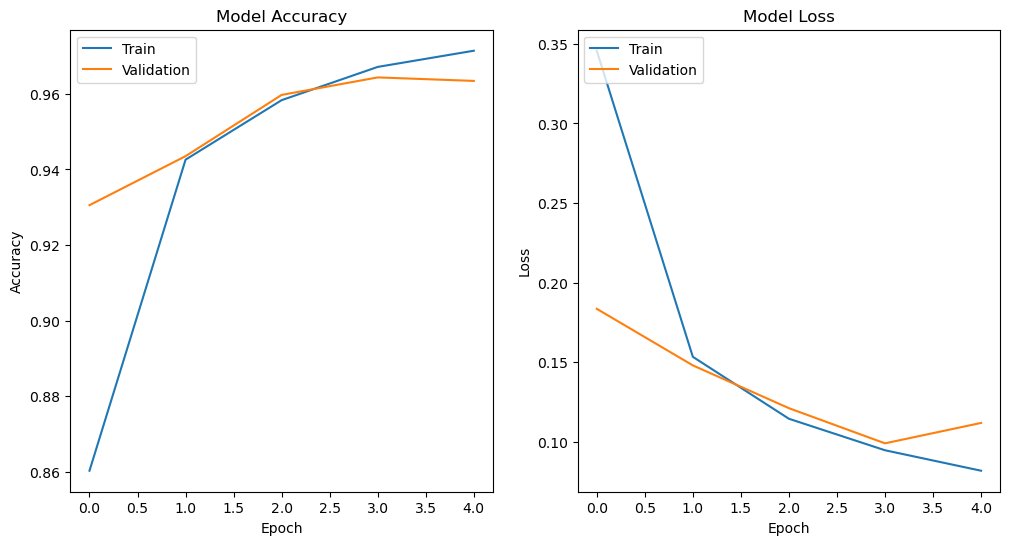

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('binaryclassificationdataset.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_ValueViolation']

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot for model accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot for model loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Save the figure
    plt.savefig('training_and_validation_accuracy.png', dpi=300)
    
    # Display the figure
    plt.show()

plot_history(history)



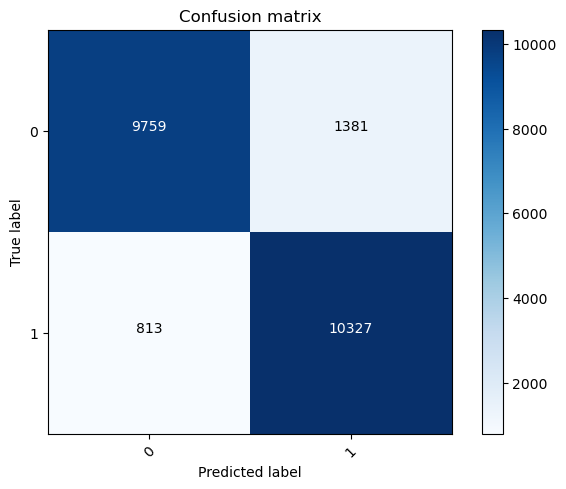

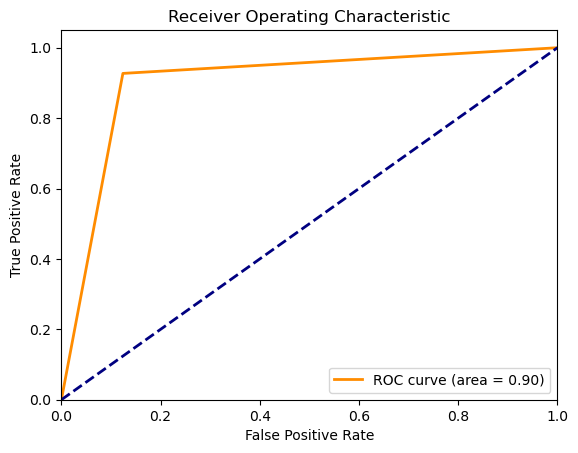

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     11140
           1       0.88      0.93      0.90     11140

    accuracy                           0.90     22280
   macro avg       0.90      0.90      0.90     22280
weighted avg       0.90      0.90      0.90     22280



In [6]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('binar_confusion_matrix_cnn.png', dpi=300)
    plt.show()
    # Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('binary_ROC_cnn.png', dpi=300)
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["0", "1"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))

Dataset loaded.

<>:49: SyntaxWarning: invalid escape sequence '\['
<>:49: SyntaxWarning: invalid escape sequence '\['
C:\Users\KHAN SHAHFAHAD\AppData\Local\Temp\ipykernel_14652\2489645467.py:49: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Downloading package punkt to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KHAN SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[


NLTK data downloaded.


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.7158 - loss: 0.5159 - val_accuracy: 0.8728 - val_loss: 0.3106
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9025 - loss: 0.2430 - val_accuracy: 0.8519 - val_loss: 0.3441
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.8122 - loss: 0.4400 - val_accuracy: 0.8596 - val_loss: 0.3107
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9051 - loss: 0.2312 - val_accuracy: 0.8833 - val_loss: 0.2846
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9232 - loss: 0.1998 - val_accuracy: 0.8985 - val_loss: 0.2613
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9359 - loss: 0.1746 - val_accuracy: 0.8781 - val_loss: 0.3122
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8050 - loss: 0.4638 - val_accuracy: 0.8033 - val_loss: 0.4340
Epoc

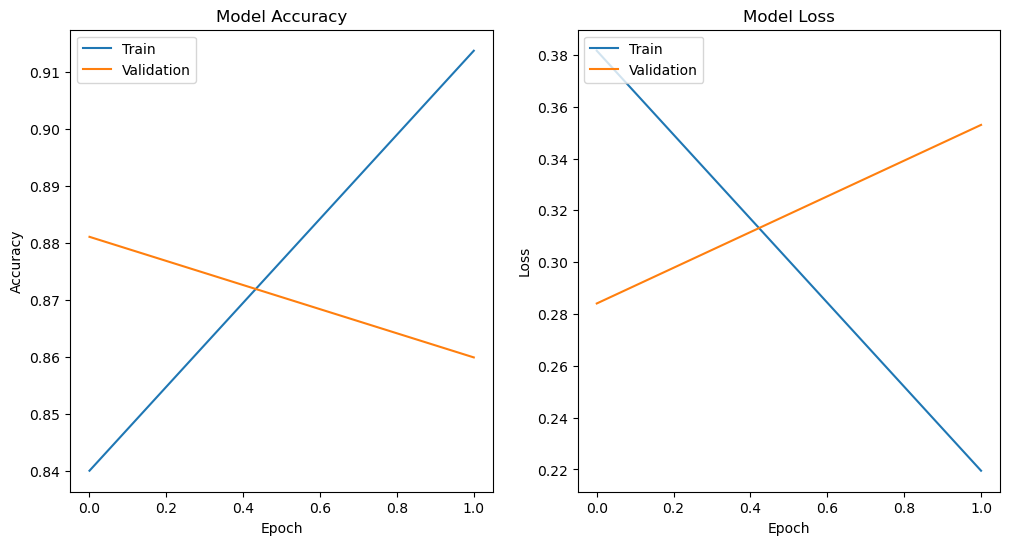

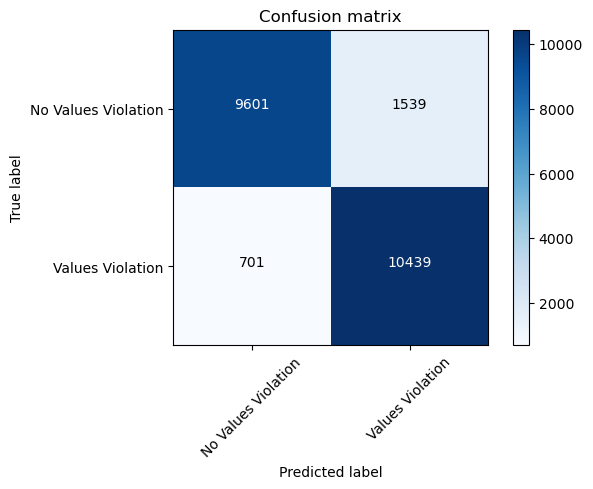

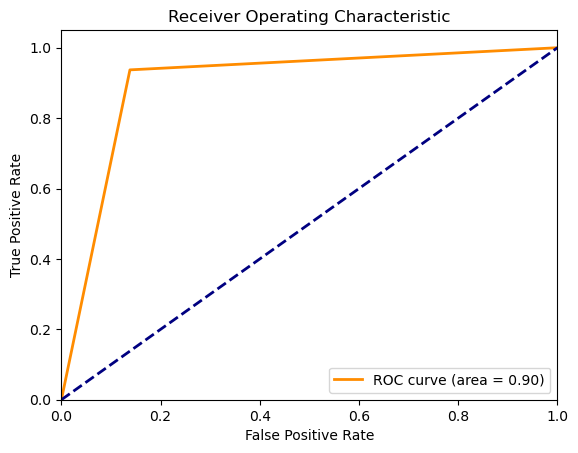

              precision    recall  f1-score   support

           0       0.93      0.86      0.90     11140
           1       0.87      0.94      0.90     11140

    accuracy                           0.90     22280
   macro avg       0.90      0.90      0.90     22280
weighted avg       0.90      0.90      0.90     22280



In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('binaryclassificationdataset.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    if pd.isna(text):
        return ""
    soup = BeautifulSoup(str(text), "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text



# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_ValueViolation']
#undersampler = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled_over, y_resampled_over = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency_over(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []
    fpr, tpr = [], []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)
        
        # Compute ROC curve
        fpr_fold, tpr_fold, _ = roc_curve(Test_Y, predictions)
        fpr.append(fpr_fold)
        tpr.append(tpr_fold)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals), fpr, tpr

# Train the model and get the history object, predictions, and actual values
history_over, all_predictions_over, all_actuals_over, fpr_over, tpr_over = get_dataset_words_frequency_over(X_resampled_over, y_resampled_over, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history_over)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals_over, all_predictions_over, classes=["No Values Violation", "Values Violation"])
plot_roc_curve(all_actuals_over, all_predictions_over)

# Print classification report
print(classification_report(all_actuals_over, all_predictions_over))


Dataset loaded.


<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
C:\Users\KHAN SHAHFAHAD\AppData\Local\Temp\ipykernel_14652\1240657129.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Downloading package punkt to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KHAN SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[

NLTK data downloaded.


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.7411 - loss: 0.5072 - val_accuracy: 0.8315 - val_loss: 0.4062
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9069 - loss: 0.2348 - val_accuracy: 0.8701 - val_loss: 0.3057
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9170 - loss: 0.2155 - val_accuracy: 0.8591 - val_loss: 0.3550
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7916 - loss: 0.4969 - val_accuracy: 0.8282 - val_loss: 0.3897
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9086 - loss: 0.2330 - val_accuracy: 0.8836 - val_loss: 0.2872
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9267 - loss: 0.1934 - val_accuracy: 0.8686 - val_loss: 0.3400
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8066 - loss: 0.4557 - val_accuracy: 0.8651 - val_loss: 0.3026
Epoc

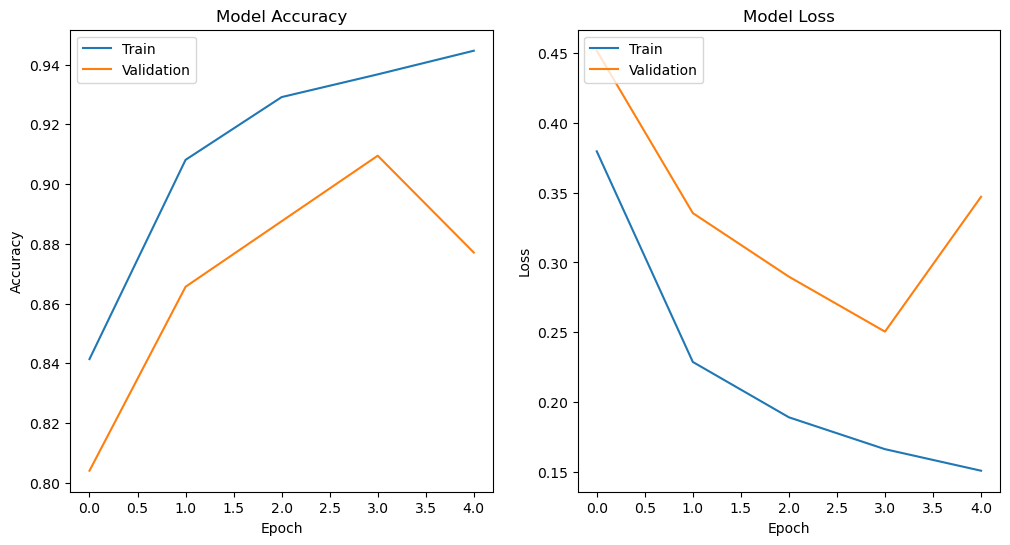

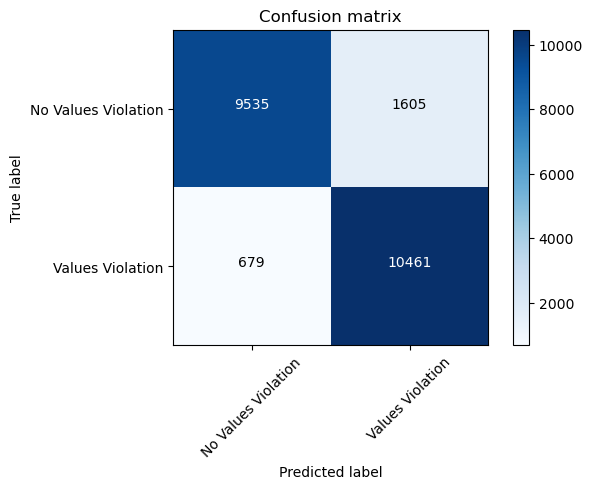

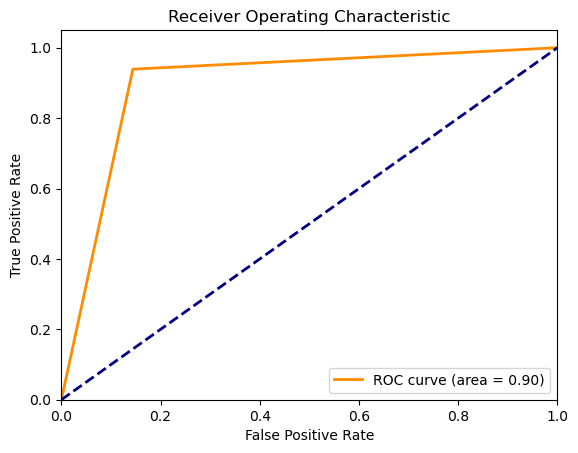

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     11140
           1       0.87      0.94      0.90     11140

    accuracy                           0.90     22280
   macro avg       0.90      0.90      0.90     22280
weighted avg       0.90      0.90      0.90     22280



In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('binaryclassificationdataset.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    if pd.isna(text):
        return ""
    soup = BeautifulSoup(str(text), "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_ValueViolation']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Values Violation", "Values Violation"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.

<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
C:\Users\KHAN SHAHFAHAD\AppData\Local\Temp\ipykernel_14652\2370927116.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Downloading package punkt to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KHAN SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[


NLTK data downloaded.


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.6880 - loss: 0.5662 - val_accuracy: 0.8497 - val_loss: 0.3353
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.8949 - loss: 0.2641 - val_accuracy: 0.8208 - val_loss: 0.4080
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.7690 - loss: 0.5216 - val_accuracy: 0.8099 - val_loss: 0.4093
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.8902 - loss: 0.2689 - val_accuracy: 0.8154 - val_loss: 0.4030
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9130 - loss: 0.2188 - val_accuracy: 0.8326 - val_loss: 0.3816
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.9283 - loss: 0.1866 - val_accuracy: 0.8087 - val_loss: 0.4407
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.7737 - loss: 0.5297 - val_accuracy: 0.7627 - val_loss: 0.5144
Epo

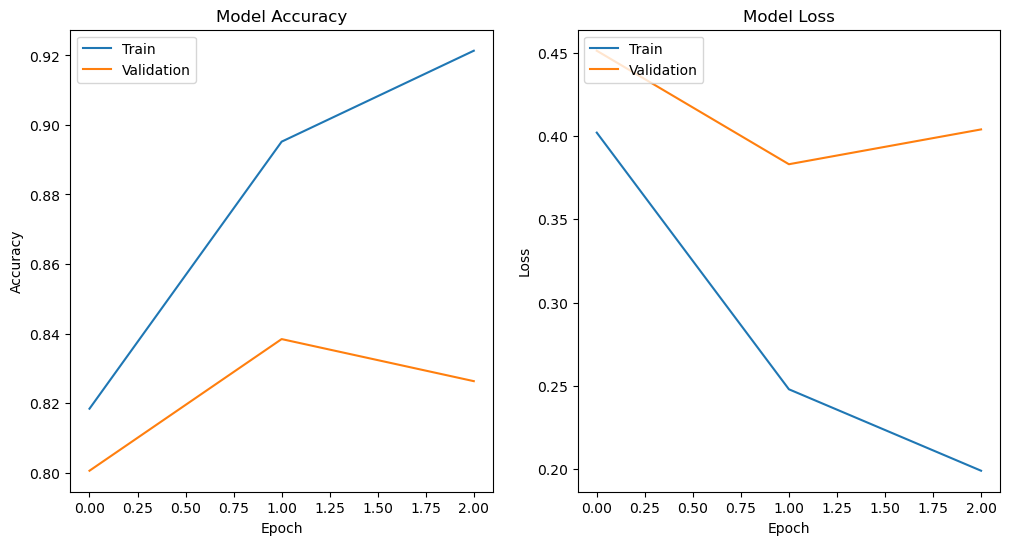

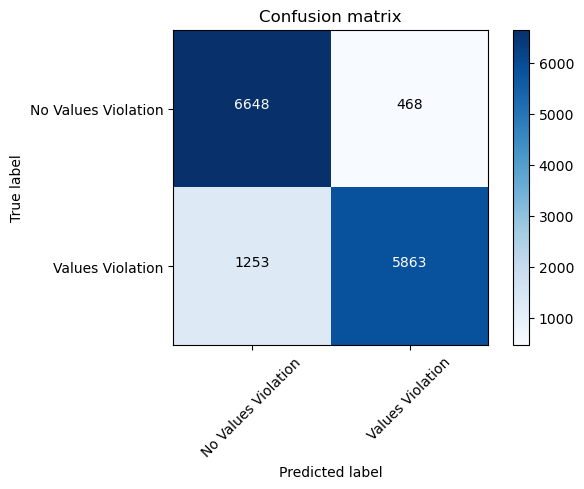

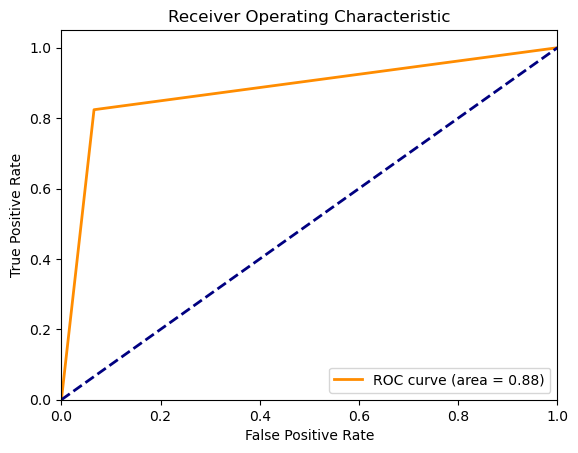

              precision    recall  f1-score   support

           0       0.84      0.93      0.89      7116
           1       0.93      0.82      0.87      7116

    accuracy                           0.88     14232
   macro avg       0.88      0.88      0.88     14232
weighted avg       0.88      0.88      0.88     14232



In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('binaryclassificationdataset.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    if pd.isna(text):
        return ""
    soup = BeautifulSoup(str(text), "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text


# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_ValueViolation']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Values Violation", "Values Violation"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.

<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
C:\Users\KHAN SHAHFAHAD\AppData\Local\Temp\ipykernel_14652\1840097510.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Downloading package punkt to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KHAN SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[


NLTK data downloaded.


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.7279 - loss: 0.5074 - val_accuracy: 0.8135 - val_loss: 0.4363
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9111 - loss: 0.2362 - val_accuracy: 0.8402 - val_loss: 0.3838
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9172 - loss: 0.2108 - val_accuracy: 0.8676 - val_loss: 0.3271
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9287 - loss: 0.1893 - val_accuracy: 0.8746 - val_loss: 0.3223
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9350 - loss: 0.1732 - val_accuracy: 0.8584 - val_loss: 0.3985
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.7216 - loss: 0.5126 - val_accuracy: 0.7916 - val_loss: 0.4754
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9039 - loss: 0.2402 - val_accuracy: 0.8507 - val_loss: 0.3658
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9204 - loss: 0.2058 - val_accuracy: 0.8634 - val_loss: 0.3400
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9263 - loss: 0.1909 - val_accuracy: 0.8701 - val_loss: 0.3365
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9367 - loss: 0.1702 - val_accuracy: 0.8901 - val_loss: 0.2967
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9394 - loss: 0.1589 - val_accuracy: 0.9190 - val_loss: 0.2276
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.9453 - loss: 0.1442 - val_accuracy: 0.8960 - val_loss: 0.2981
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.7390 - loss: 0.4987 - val_accuracy: 0.8534 - val_loss: 0.3541
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9116 - loss: 0.2346 - val_accuracy: 0.8783 - val_loss: 0.2969
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9186 - loss: 0.2095 - val_accuracy: 0.8551 - val_loss: 0.3660
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.7396 - loss: 0.5008 - val_accuracy: 0.8609 - val_loss: 0.3392
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9038 - loss: 0.2378 - val_accuracy: 0.8704 - val_loss: 0.3076
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9186 - loss: 0.2139 - val_accuracy: 0.8659 - val_loss: 0.3291
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.7421 - loss: 0.5016 - val_accuracy: 0.8270 - val_loss: 0.3889
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9077 - loss: 0.2349 - val_accuracy: 0.8788 - val_loss: 0.2847
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9212 - loss: 0.2065 - val_accuracy: 0.8768 - val_loss: 0.2879
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.7236 - loss: 0.5130 - val_accuracy: 0.8517 - val_loss: 0.3418
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9062 - loss: 0.2357 - val_accuracy: 0.8898 - val_loss: 0.2561
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9198 - loss: 0.2070 - val_accuracy: 0.8384 - val_loss: 0.4000
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.7471 - loss: 0.4970 - val_accuracy: 0.8409 - val_loss: 0.3579
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9052 - loss: 0.2357 - val_accuracy: 0.8659 - val_loss: 0.3300
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.9142 - loss: 0.2134 - val_accuracy: 0.8631 - val_loss: 0.3323
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7442 - loss: 0.4994 - val_accuracy: 0.8414 - val_loss: 0.3713
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.9123 - loss: 0.2320 - val_accuracy: 0.8614 - val_loss: 0.3478
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9165 - loss: 0.2149 - val_accuracy: 0.8704 - val_loss: 0.3147
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9271 - loss: 0.1983 - val_accuracy: 0.8569 - val_loss: 0.3597
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.7317 - loss: 0.5063 - val_accuracy: 0.8564 - val_loss: 0.3288
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9060 - loss: 0.2421 - val_accuracy: 0.8768 - val_loss: 0.2909
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9231 - loss: 0.2016 - val_accuracy: 0.8758 - val_loss: 0.3104
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.7280 - loss: 0.5063 - val_accuracy: 0.8153 - val_loss: 0.4362
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9068 - loss: 0.2398 - val_accuracy: 0.8360 - val_loss: 0.4019
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9213 - loss: 0.2078 - val_accuracy: 0.8676 - val_loss: 0.3169
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9245 - loss: 0.1902 - val_accuracy: 0.8771 - val_loss: 0.3097
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9356 - loss: 0.1681 - val_accuracy: 0.8848 - val_loss: 0.3126
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


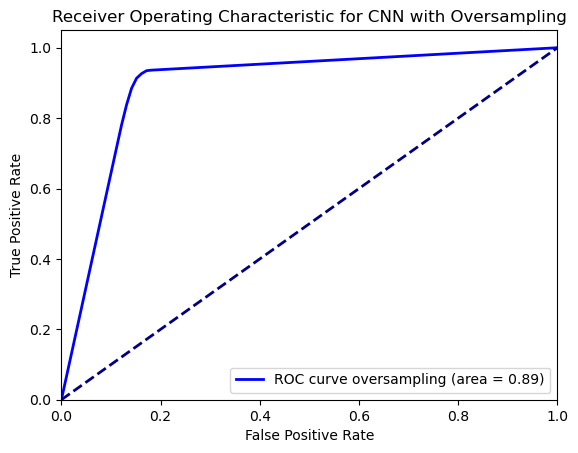

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     11140
           1       0.86      0.93      0.90     11140

    accuracy                           0.89     22280
   macro avg       0.90      0.89      0.89     22280
weighted avg       0.90      0.89      0.89     22280



In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('binaryclassificationdataset.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    if pd.isna(text):
        return ""
    soup = BeautifulSoup(str(text), "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_ValueViolation']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predicted_targets = []
    all_actual_targets = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_CNN_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predicted_targets.extend(predictions)
        all_actual_targets.extend(Test_Y)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc, all_predicted_targets, all_actual_targets

# Get ROC data
mean_fpr_over, mean_tpr_over, mean_auc_over, all_predictions_over, all_actuals_over = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot ROC Curve
plt.figure()
plt.plot(mean_fpr_over, mean_tpr_over, color='blue', lw=2, label='ROC curve oversampling (area = %0.2f)' % mean_auc_over)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN with Oversampling')
plt.legend(loc="lower right")
plt.show()

# Print classification report for oversampling
print(classification_report(all_actuals_over, all_predictions_over))


Dataset loaded.
NLTK data downloaded.


<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
C:\Users\KHAN SHAHFAHAD\AppData\Local\Temp\ipykernel_14652\2122661363.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Downloading package punkt to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KHAN SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KHAN
[nltk_data]     SHAHFAHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[

Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.6944 - loss: 0.5685 - val_accuracy: 0.7947 - val_loss: 0.4497
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.8968 - loss: 0.2595 - val_accuracy: 0.8247 - val_loss: 0.3881
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9163 - loss: 0.2159 - val_accuracy: 0.8322 - val_loss: 0.3869
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9249 - loss: 0.1943 - val_accuracy: 0.8290 - val_loss: 0.3963
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7083 - loss: 0.5585 - val_accuracy: 0.7771 - val_loss: 0.4847
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.8938 - loss: 0.2608 - val_accuracy: 0.8595 - val_loss: 0.3177
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.9176 - loss: 0.2095 - val_accuracy: 0.8349 - val_loss: 0.3827
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.7002 - loss: 0.5585 - val_accuracy: 0.8365 - val_loss: 0.3729
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9012 - loss: 0.2558 - val_accuracy: 0.8478 - val_loss: 0.3560
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9166 - loss: 0.2119 - val_accuracy: 0.8638 - val_loss: 0.3584
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.7072 - loss: 0.5614 - val_accuracy: 0.8329 - val_loss: 0.3727
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9001 - loss: 0.2555 - val_accuracy: 0.7955 - val_loss: 0.4542
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.6953 - loss: 0.5684 - val_accuracy: 0.7869 - val_loss: 0.4518
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8980 - loss: 0.2542 - val_accuracy: 0.7963 - val_loss: 0.4674
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.6909 - loss: 0.5669 - val_accuracy: 0.8228 - val_loss: 0.3873
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8909 - loss: 0.2680 - val_accuracy: 0.8595 - val_loss: 0.3278
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9150 - loss: 0.2158 - val_accuracy: 0.8283 - val_loss: 0.4009
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.6834 - loss: 0.5663 - val_accuracy: 0.8224 - val_loss: 0.3828
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.8896 - loss: 0.2658 - val_accuracy: 0.8423 - val_loss: 0.3679
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9202 - loss: 0.2103 - val_accuracy: 0.8290 - val_loss: 0.3888
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.6985 - loss: 0.5636 - val_accuracy: 0.8333 - val_loss: 0.3798
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8964 - loss: 0.2603 - val_accuracy: 0.8232 - val_loss: 0.4066
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7001 - loss: 0.5668 - val_accuracy: 0.8349 - val_loss: 0.3745
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.9016 - loss: 0.2528 - val_accuracy: 0.8372 - val_loss: 0.3753
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/10


C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.6939 - loss: 0.5680 - val_accuracy: 0.7896 - val_loss: 0.4717
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.8965 - loss: 0.2569 - val_accuracy: 0.8283 - val_loss: 0.3885
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9174 - loss: 0.2120 - val_accuracy: 0.8212 - val_loss: 0.4226
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


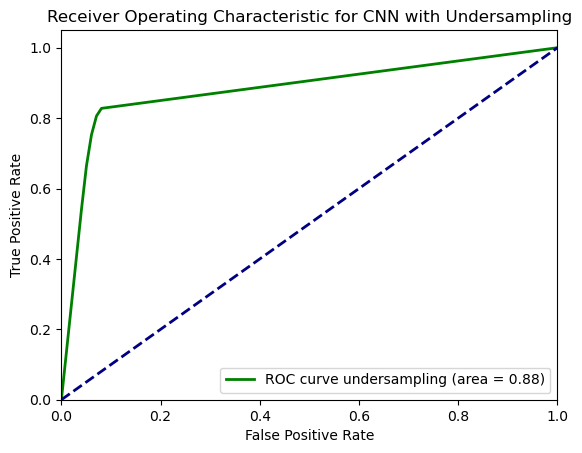

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7116
           1       0.93      0.82      0.87      7116

    accuracy                           0.88     14232
   macro avg       0.89      0.88      0.88     14232
weighted avg       0.89      0.88      0.88     14232



In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('binaryclassificationdataset.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    if pd.isna(text):
        return ""
    soup = BeautifulSoup(str(text), "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text


# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_ValueViolation']
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model_under = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency_under(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score_under = []
    all_predictions_under = []
    all_actuals_under = []
    tprs_under = []
    mean_fpr_under = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_CNN_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs_under.append(np.interp(mean_fpr_under, fpr, tpr))
        tprs_under[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predictions_under.extend(predictions)
        all_actuals_under.extend(Test_Y)

    mean_tpr_under = np.mean(tprs_under, axis=0)
    mean_tpr_under[-1] = 1.0
    mean_auc_under = auc(mean_fpr_under, mean_tpr_under)

    return mean_fpr_under, mean_tpr_under, mean_auc_under, all_predictions_under, all_actuals_under

# Get ROC data for undersampling
mean_fpr_under, mean_tpr_under, mean_auc_under, all_predictions_under, all_actuals_under = get_dataset_words_frequency_under(X_resampled_under, y_resampled_under, max_words, max_len)

# Plot ROC Curve for Undersampling
plt.figure()
plt.plot(mean_fpr_under, mean_tpr_under, color='green', lw=2, label='ROC curve undersampling (area = %0.2f)' % mean_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN with Undersampling')
plt.legend(loc="lower right")
plt.show()

# Print classification report for undersampling
print(classification_report(all_actuals_under, all_predictions_under))


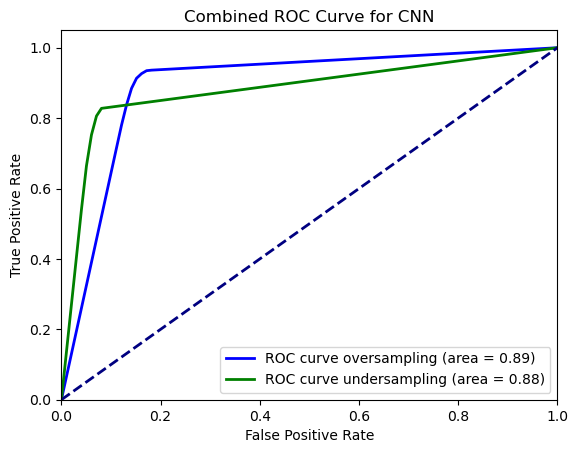

In [24]:
import matplotlib.pyplot as plt

# Make sure to run the oversampling and undersampling code blocks before this to get the ROC data
plt.figure()
plt.plot(mean_fpr_over, mean_tpr_over, color='blue', lw=2, label='ROC curve oversampling (area = %0.2f)' % mean_auc_over)
plt.plot(mean_fpr_under, mean_tpr_under, color='green', lw=2, label='ROC curve undersampling (area = %0.2f)' % mean_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the plot
plt.savefig('binaryCNNcombined_roc_curve.jpeg', dpi=300)

plt.show()
